<a href="https://colab.research.google.com/github/NRmethun/ML-DL-Notebook/blob/main/one_shot_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds


In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 500
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5


In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        # ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)

        ds = keras.preprocessing.image_dataset_from_directory(
            directory="/content/drive/MyDrive/Chammaw/chakma-alphabet",
            image_size=(28, 28), batch_size=32,
            shuffle=True, seed=None, validation_split=None,
           ).map(lambda x: x / 255.0)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)


Found 420 files belonging to 21 classes.


TypeError: ignored

['Validate', 'Train', 'Test']
Healthy  hh 
/content/drive/MyDrive/Carrots-Diff/Train/Healthy
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/1.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/2.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/3.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/4.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/5.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/6.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/7.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/8.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/9.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/10.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/11.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/12.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/13.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/14.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/15.jpg
/content/drive/MyDrive/Carrots-Diff/Train/Healthy/16.jpg
/con

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: ignored

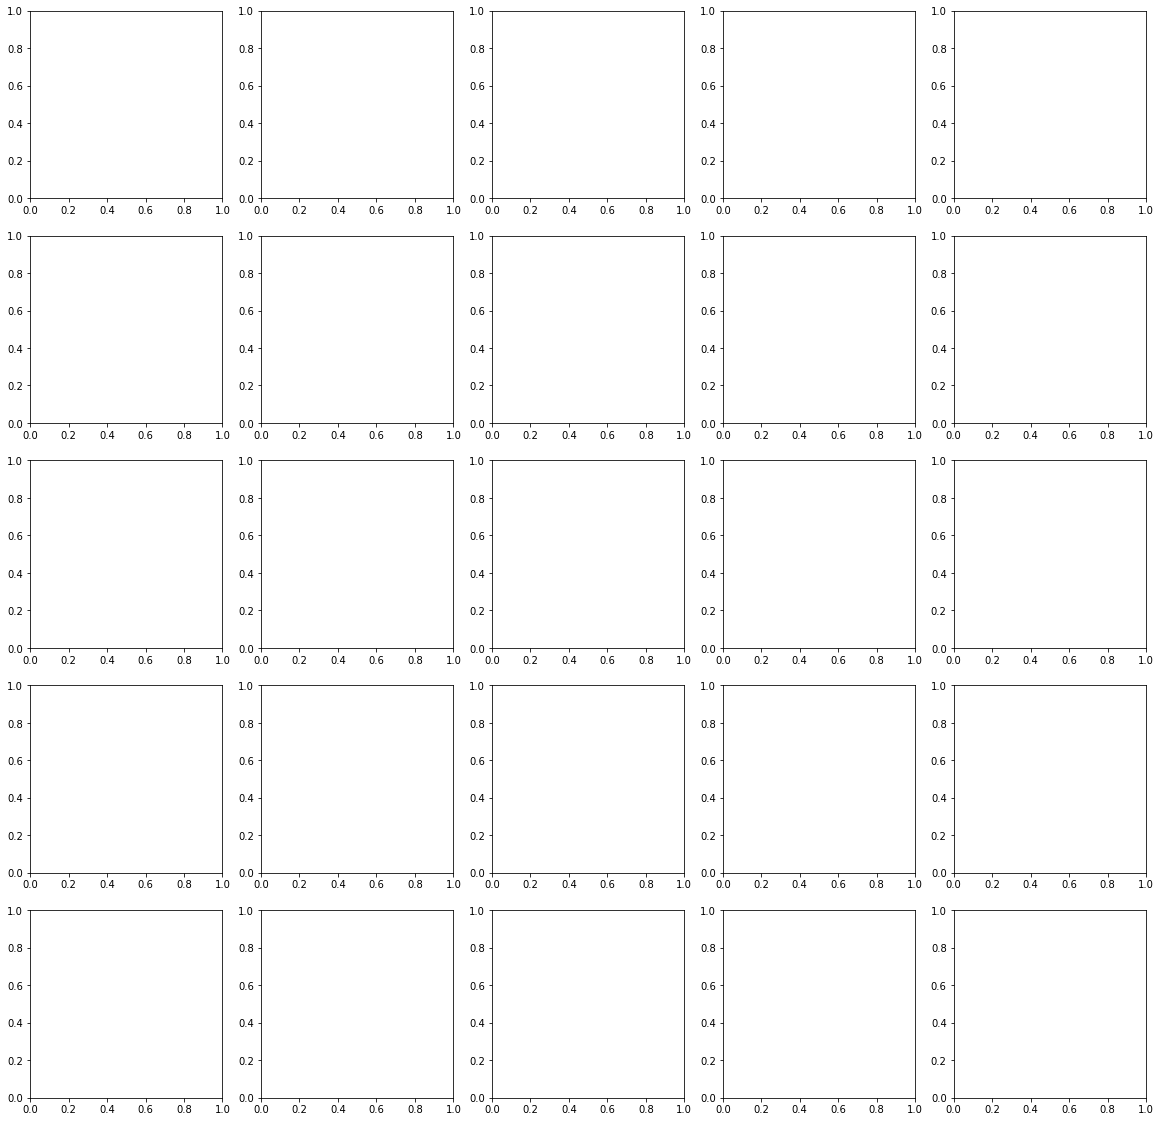

In [ ]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()


In [ ]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


In [ ]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


batch 0: train=0.400000 test=0.400000
batch 100: train=0.800000 test=1.000000
batch 200: train=0.600000 test=1.000000
batch 300: train=0.600000 test=1.000000
batch 400: train=0.600000 test=0.800000


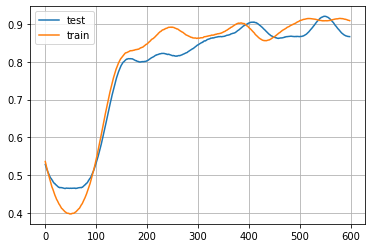

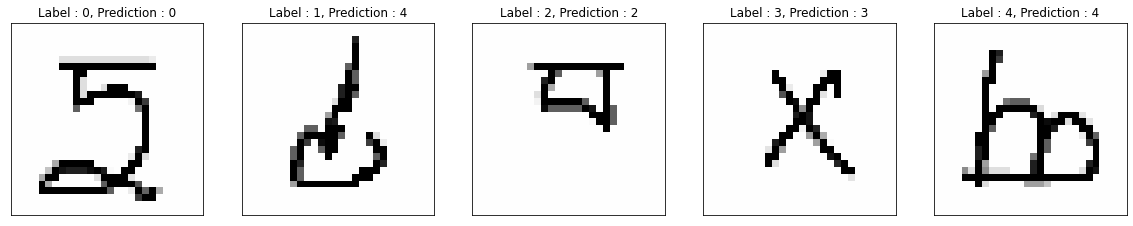

In [ ]:
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()


# finish here

In [ ]:


base_class_name = 'character'

def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes



In [ ]:
classes = gen_class_names(base_class_name)
print(classes)

['character01', 'character02', 'character03', 'character04', 'character05', 'character06', 'character07', 'character08', 'character09', 'character10', 'character11', 'character12', 'character13', 'character14', 'character15', 'character16', 'character17', 'character18', 'character19', 'character20']


In [ ]:
from sklearn.preprocessing import LabelBinarizer

def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [ ]:
labels = generate_one_hot_encoding(classes)
print(labels)
len(labels)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


20

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    return siamese_net

In [ ]:
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]             

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Sanskrit language, 20 samples of the third character.


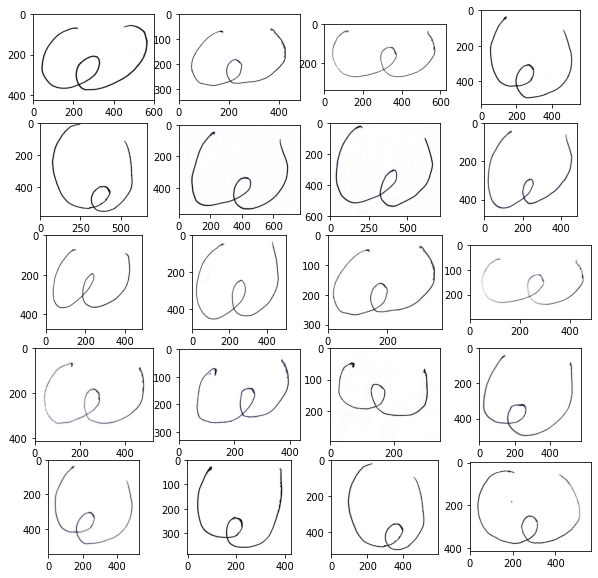

In [ ]:
plot_images('/content/drive/MyDrive/chakma-alphabet/1/')
print("Sanskrit language, 20 samples of the third character.")

In [ ]:
import pickle

with open(os.path.join(project_path), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(project_path ), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Training alphabets: \n")
print(len(list(classes.keys())))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))
X = chakma-alphabet
print(X.shape)

IsADirectoryError: ignored

In [ ]:
import numpy.random as rng
import numpy as np
from sklearn.utils import shuffle

class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}

        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category
            else:
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets

    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)

        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets

    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct

    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))


loader = Siamese_Loader(project_path)

loading data from /content/drive/MyDrive/chakma-alphabet/train.pickle


FileNotFoundError: ignored

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

NameError: ignored

In [ ]:
import time

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 150
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss))
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(project_path))
            model.save_weights(project_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))


# weights_path = os.path.join(project_path, "model_weights.h5")
# model.load_weights(weights_path)

Starting training process!
-------------------------------------


NameError: ignored

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0

    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 20, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))

#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

NameError: ignored